Install and load all dependencies (first time only) \
NOTE: you may need to restart the runtime afterwards (CTRL+M .).

In [ ]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

!pip install gym
!pip install free-mujoco-py
!pip install stable-baselines3[extra]

Set up the custom Hopper environment and provided util functions



1.   Upload `our_hopper.zip` to the current session's file storage
2.   Un-zip it by running cell below


In [ ]:
!unzip our_hopper.zip



---



In [ ]:
import gym
from env.custom_hopper import *
from stable_baselines3 import SAC
import numpy as np
import tqdm
import rich

***Action Space***: The action space is a `Box(-1, 1, (3,), float32)`. An action represents the torques applied at the hinge joints.

***Observation Space***: Observations consist of positional values of different body parts of the hopper, followed by the velocities of those individual parts (their derivatives) with all the positions ordered before all the velocities.  
By default, the observation is a `Box(-Inf, Inf, (11,), float64)` with different elements of the hopper.



In [ ]:
# create environment

source_env = gym.make('CustomHopper-source-v0') # [2.53429174 3.92699082 2.71433605 5.0893801 ]
target_env = gym.make('CustomHopper-target-v0') # [3.53429174 3.92699082 2.71433605 5.0893801 ]


print('State space:', source_env.observation_space)  # state-space
print('Action space:', source_env.action_space)  # action-space
print('Dynamics parameters source:', source_env.get_parameters())  # masses of each link of the Hopper
print('Dynamics parameters target:', target_env.get_parameters())  # masses of each link of the Hopper


***`EvalCallback`***: Evaluate periodically the performance of an agent. It will save the best model if `best_model_save_path` folder is specified and save the evaluations results in a numpy archive `(evaluations.npz)` if `log_path` folder is specified.

In [ ]:
from stable_baselines3.common.callbacks import EvalCallback

# Use deterministic actions for evaluation
eval_callback = EvalCallback(source_env, best_model_save_path="./logs/",
                             log_path="./logs/", eval_freq=3_000,
                             deterministic=True, render=False)

***Soft Actor Critic (SAC)***: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor.

In [ ]:
# load model with MLP Policy for source environment.
model = SAC("MlpPolicy", source_env, verbose=0, learning_rate= 1e-3, learning_starts=200)

# train model with source environment.
model.learn(total_timesteps=300_000, log_interval=4, callback=eval_callback, progress_bar=True)

In [ ]:
# load model with MLP Policy for target environment.
target_model = SAC("MlpPolicy", target_env, verbose=0, learning_rate= 1e-3, learning_starts=200)


# train target model with target environment.
target_model.learn(total_timesteps=300_000, log_interval=4,  progress_bar=True)

In [ ]:
# display improvement during training
data_dict = dict(np.load('/content/logs/evaluations.npz'))
timesteps = data_dict['timesteps']
rewards = data_dict['results']
ep_length = data_dict['ep_lengths']

***`evaluate_policy`***: Runs policy for `n_eval_episodes` episodes and returns average reward. It technically evaluates the trained policy on the environment chosen.

In [ ]:
# function to replace own evaluate functions
from stable_baselines3.common.evaluation import evaluate_policy


mean_reward, std_reward = evaluate_policy(model, source_env, n_eval_episodes=50)
print(f"mean_reward source-source:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward, std_reward = evaluate_policy(model, target_env, n_eval_episodes=50)
print(f"mean_reward source-target:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward, std_reward = evaluate_policy(target_model, target_env, n_eval_episodes=50)
print(f"mean_reward target-target:{mean_reward:.2f} +/- {std_reward:.2f}")

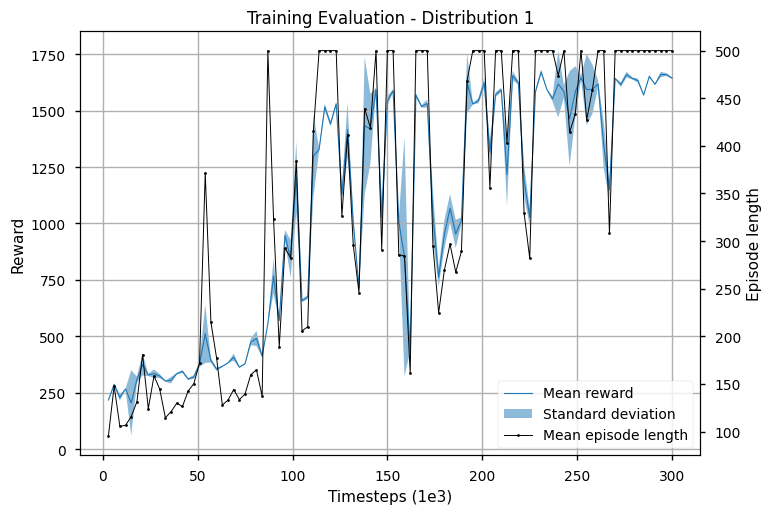

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib as mpl

# back to default settings
mpl.rcParams.update(mpl.rcParamsDefault)

# use a theme
style.use('seaborn-notebook')

x = timesteps/1000
means = np.mean(rewards, axis=1)
stds = np.std(rewards, axis=1)
ep_length_mean = np.mean(ep_length, axis=1)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

lns1 = ax1.plot(x, means, linewidth = 0.8,label='Mean reward')
lns2 = ax1.fill_between(x, means - stds, means + stds, alpha=0.5, label='Standard deviation')
lns3 = ax2.plot(x, ep_length_mean, "-o", markersize=2, linewidth = 0.7, color='black', alpha=1, label='Mean episode length')

lns = lns1+[lns2]+lns3
labs = [line.get_label() for line in lns]
ax1.legend(lns, labs, loc='lower right')

ax1.grid()
plt.title('Training Evaluation - Distribution 1', fontsize=12)
ax1.set_xlabel('Timesteps (1e3)')
ax1.set_ylabel('Reward')
ax2.set_ylabel('Episode length')

fig.savefig('reward.png')
plt.show()